In [9]:
import tempfile
import aimedicine.USDicom as USDicom
import cv2
import pydicom as dicom
import matplotlib.pyplot as plt
import aimedicine.BUModel as BUModel


from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

bu_model = None

(192, 192, 3)
C:\Users\Yuan\Desktop\Tibame\aimedicine\labelImg-master\aimedicine//logs
C:\Users\Yuan\Desktop\Tibame\aimedicine\labelImg-master\aimedicine//logs\breast_ultrasound20190122T1346\mask_rcnn_breast_ultrasound_0398.h5
Loading weights from  C:\Users\Yuan\Desktop\Tibame\aimedicine\labelImg-master\aimedicine//logs\breast_ultrasound20190122T1346\mask_rcnn_breast_ultrasound_0398.h5
Re-starting from epoch 398
Processing 1 images
image                    shape: (192, 192, 3)         min:    3.00000  max:  209.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -120.70000  max:  105.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  192.00000  int32
anchors                  shape: (1, 9207, 4)          min:   -0.71081  max:    1.37573  float32
預測的位置與BI-RYAS:  [2 2]


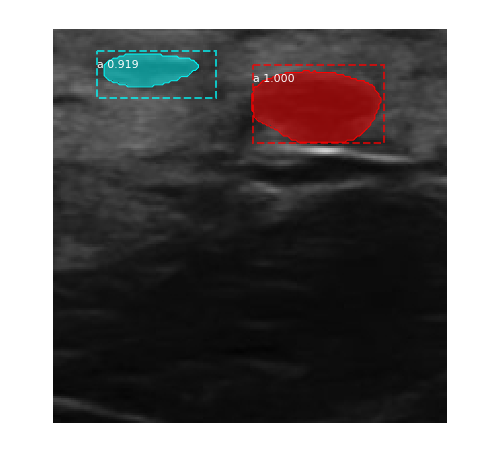

In [10]:
rect_point = [(150, 200), (342, 392)] # test 
#click_point = (200, 280) # four
check_point = (200, 300) # two

img = cv2.imread('img/BIRADS_2_md00_Image_005_left_0125035040.jpg')
img = cv2.resize(img, (192, 192))
print (img.shape) # column , row
#display_mixed_image(img, 192, 192)

#if bu_model is None:
bu_model = BUModel.BUModelClass()
bu_model.prepare_model()

results = bu_model.predict_model([img])
r = results[0]
print('預測的位置與BI-RYAS: ', r['class_ids'] + 1)
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                           'valid', r['scores'], figsize=(8, 8) ) #ax=get_ax()

(50, 100)
(((97, 31), (159, 35), (127, 20), (119, 54)), 0.621, 0.349)
horizontal axis :  (97, 31) (159, 35) 0.621
vertical axis :  (127, 20) (119, 54) 0.349
region of insterest : 0.174 cm2 
51


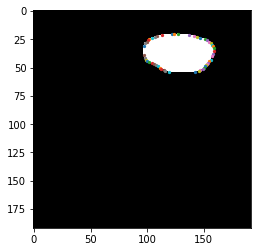

In [11]:

bu_model.region_of_interest(r, check_point,  rect_point)
axis_val = bu_model.get_axis_information()
print (axis_val)
print ('horizontal axis : ', axis_val[0][0], axis_val[0][1], axis_val[-2])
print ('vertical axis : ', axis_val[0][2] , axis_val[0][3], axis_val[-1])

region_area = bu_model.get_region_area()
print ('region of insterest : {} cm2 '.format(region_area))

side_point = bu_model.get_side_points()
print (len(side_point))

for pt in side_point:
    plt.scatter(pt[0], pt[1] , s=5)
    
mask = bu_model.get_mask()
mask = mask * 255         
plt.imshow(mask, cmap=plt.cm.gray)
plt.show()



In [ ]:
 
us_dicom = USDicom.USDicomClass("d:\\test.dcm", False)

#img = cv2.imread('img/md00_Image_005.jpg')
#img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          
#print (img.shape) # column , row
#img2 = cv2.imread('C:/Users/Yuan/Desktop/Tibame/BIRADS_2_md00_Image_005_0113015816_mask.jpg' )     
#img2 = cv2.resize(img2, (IMAGE_WIDTH, IMAGE_HEIGHT))
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)   
#img_list = np.concatenate((img,img2), axis=0) # add more one image  
#write_dicom(img_list, 2, IMAGE_WIDTH, IMAGE_HEIGHT, 'd:\\test.dcm')
#us_dicom.setUSImage(img, img.shape[1], img.shape[0])
#us_dicom.setRegion((20,20,40,40), 0x01) # tissue 
#us_dicom.setRegion((25,25,35,35), 0x02) # tissue
#us_dicom.save()

element_list =[]
us_dicom.readDataset(element_list)

for i, items in enumerate(element_list): 
    if str(items[0]) !='(7fe0, 0010)':
        print (items)
        
getImgs = us_dicom.getImages()
rect_box_list = us_dicom.getRegionBox(1)
for rect_box in rect_box_list:
    cv2.rectangle(getImgs, rect_box[0], rect_box[1] , (255, 255, 255), 2)
    
plt.imshow(getImgs, cmap=plt.cm.gray)
plt.show()


In [8]:
import datetime
import time
from pydicom.dataset import Dataset, FileDataset
from matplotlib import pyplot as plt
from pydicom.sequence import Sequence
import numpy as np
import pydicom as dicom

from pydicom.datadict import DicomDictionary, keyword_dict
from pydicom.dataset import Dataset

"""
TAG_DESCRIBES = {
                    '(0008, 0008)':'Image Type', 
                    '(0008, 0016)': 'SOP Class UID'  
                }
"""

class USDicomClass2(object):   
    MIN_X0 = 0x00186018
    MIN_Y0 = 0x0018601A
    MAX_X1 = 0x0018601C
    MAX_Y1 = 0x0018601E
    
    def __init__(self, file_name, IsCreate=False):           
        ## This code block was taken from the output of a MATLAB secondary
        ## capture.  I do not know what the long dotted UIDs mean, but
        ## this code works.
        if IsCreate:
            self.__file_name__ = file_name
            file_meta = Dataset()
    
            # Ultrasound Multiframe Image Storage - https://www.dicomlibrary.com/dicom/sop/
            file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.3.1' 
            file_meta.MediaStorageSOPInstanceUID = '999.999.2.19941105.134500.2.101'
            file_meta.ImplementationClassUID = '999.999'
            # Transfer Syntax - https://www.dicomlibrary.com/dicom/transfer-syntax/
            file_meta.TransferSyntaxUID='1.2.840.10008.1.2'
 
            ds = FileDataset(file_name, {},file_meta = file_meta, preamble=b"\0"*128)
            # DICOM modality, that represents DICOM file type - https://www.dicomlibrary.com/dicom/modality/
            ds.Modality = 'US' # Ultrasound
            ds.ContentDate = str(datetime.date.today()).replace('-','')
            ds.ContentTime = str(time.time()) #milliseconds since the epoch
            ds.StudyInstanceUID =  '999.999.2.19941105.134500'
            ds.SeriesInstanceUID = '999.999.2.19941105.134500.2'
            ds.SOPInstanceUID = '999.999.2.19941105.134500.2.101'
    
            # https://searchcode.com/codesearch/view/13929148/
            ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.3.1'  # 'Ultrasound Multi-frame Image Storage' - 1.2.840.10008.5.1.4.1.1.3.1   
            # ds.SecondaryCaptureDeviceManufctur = 'Python 2.7.3'
            self.Dataset = ds      
        else:
            self.Dataset =dicom.read_file(file_name)
            
           
            """
            self.Dataset.add_new((0x7FE1, 0x0010), 'SQ', []) 
            self.Dataset[0x7FE10010].value.append(Dataset())
            self.Dataset[0x7FE10010].value[-1].add_new((0x0018, 0x0002), 'FD', 1.23)
            self.Dataset[0x7FE10010].value[-1].add_new((0x0018, 0x0003), 'FD', 0.4)
            self.Dataset[0x7FE10010].value[-1].add_new((0x0018, 0x0004), 'FD', 0.22)
            """
            
    def setUSImage(self, image_array, image_width, image_height):
        # https://dicom.innolitics.com/ciods/ophthalmic-photography-8-bit-image/ophthalmic-photography-image/00280002 
        ## These are the necessary imaging components of the FileDataset object.
        # Dicom tag - https://www.dicomlibrary.com/dicom/dicom-tags/
        self.Dataset.add_new(0x00280008,'IS', 1) #  Number of Frames : can setting more one
        self.Dataset.add_new(0x00181063,'DS', 100000) #  Frames Time
        self.Dataset.add_new(0x00082128,'IS', 1) #  View Number
        self.Dataset.add_new(0x00080008,'CS','ORIGINAL\PRIMARY\BU\0001') # Image Type      
        self.Dataset.SamplesPerPixel = 1
        self.Dataset.PhotometricInterpretation = "MONOCHROME2"
        self.Dataset.PixelRepresentation = 0 # unsigned integer.
        self.Dataset.HighBit = 7 #15
        self.Dataset.BitsStored = 8 #16
        self.Dataset.BitsAllocated = 8 #16
        #ds.SmallestImagePixelValue =  0 #'\\x00\\x00'
        #ds.LargestImagePixelValue =  255 # '\\xff\\xff'
        self.Dataset.Columns = image_width #pixel_array.shape[0]
        self.Dataset.Rows = image_height #pixel_array.shape[1]
        #pixel_array = image_array.astype(np.uint8)
        #if pixel_array.dtype != np.uint16:
        #    pixel_array = pixel_array.astype(np.uint16)
        self.Dataset.PixelData = image_array.astype(np.uint8).tostring()       
        self.Dataset.add_new((0x0018, 0x6011), 'SQ', [])            
       


    def setRegion(self, region_rect , region_type=0x1):
        # split retangle  to DL 
        # http://northstar-www.dartmouth.edu/doc/idl/html_6.2/DICOM_Attributes.html
        # http://dicom.nema.org/medical/dicom/2016e/output/chtml/part03/sect_C.8.5.5.html
        # https://imagej.nih.gov/nih-image/download/nih-image_spin-offs/NucMed_Image/DICOM%20Dictionary            
        ds = Dataset()        
        ds.add_new((0x0018, 0x6018), 'UL', region_rect[0]) # Region Location Min X0 
        ds.add_new((0x0018, 0x601A), 'UL', region_rect[1]) # Region Location Min Y0  
        ds.add_new((0x0018, 0x601C), 'UL', region_rect[2] ) # Region Location Max X1
        ds.add_new((0x0018, 0x601E), 'UL', region_rect[3]) # Region Location Max Y1       
        ds.add_new((0x0018, 0x6024), 'UL', 0x3) # Physical Units X Direction 0x3:cm 
        ds.add_new((0x0018, 0x6026), 'UL', 0x3) # Physical Units Y Direction 0x3:cm
        ds.add_new((0x0018, 0x602C), 'FD', 0.05) # Physical Delta X 1 pixel : 0.05 mm
        ds.add_new((0x0018, 0x602E), 'FD', 0.05) # Physical Delta Y 1 pixel : 0.05 mm    
        ds.add_new((0x0018, 0x6012), 'US', 0x1)  # Region Spatial Format 0x1 : 2D (tissue or flow)
        ds.add_new((0x0018, 0x6014), 'US', region_type)  # Region Data Type 0x1: Tissue 0x2 : Clor Flow
        ds.add_new((0x0018, 0x6016), 'UL', 0x0)  #  Region Flags  0: Region pixels are high priority        
        self.Dataset[0x00186011].value.append(ds)
    
    def __parsing_data_set__(self, dataset, element_list):
        for sequence_item in dataset:            
            element_list.append((sequence_item.tag, sequence_item.name, sequence_item.VR, 
                                 sequence_item.VM , sequence_item.value)) 
            if sequence_item.VR == "SQ":   # a sequence   
                for seq_item in data_element.value:
                    self.__parsing_data_set__(seq_item, element_list)
    
    def readDataset(self, element_list):         
        for data_element in self.Dataset:
            element_list.append((data_element.tag, data_element.name, data_element.VR, data_element.VM , data_element.value))       
            if data_element.VR == "SQ":   # a sequence         
                 for sequence_item in data_element.value:
                    self.__parsing_data_set__(sequence_item, element_list)
                    
    def getImages(self):
        return self.Dataset.pixel_array
    
    def getRegionBox(self, region_type):
        rect_box_list=[]
        region_area = self.Dataset[0x00186011].value
        if len(region_area) > 0:
            for i, reg in enumerate(region_area):    
                if (reg[0x00186014].value == region_type):
                    rect_box_list.append(((reg[self.MIN_X0].value, reg[self.MIN_Y0].value), 
                                          (reg[self.MAX_X1].value, reg[self.MAX_Y1].value)))
        return rect_box_list
    
    def getPrivateCreator(self):
        private_list = self.Dataset[0x7FE10010]
        horizontal_len = 0
        vertical_len = 0
        tumor_area = 0
        private_data = []
        if private_list is not None:
            #private_table_list = self.Dataset[0x30031000].value
            #if index < len(private_list):
            for index, private_table in enumerate(private_list):
                horizontal_len = private_table[0x00180002].value
                vertical_len = private_table[0x00180003].value
                tumor_area = private_table[0x00180004].value
                private_data.append((horizontal_len, vertical_len, tumor_area))
        return private_data
    
    def save(self): 
        self.Dataset.save_as('d://test.dcm')
         

[(1.23, 0.4, 0.22)]


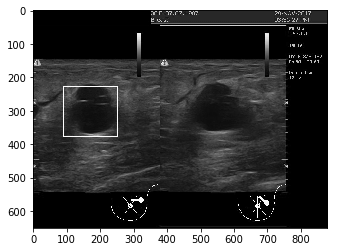

In [9]:
import cv2
#us_dicom2 = USDicomClass2("D://md09_Image_014.dcm", False)
us_dicom2 = USDicomClass2("D://test.dcm", False)
#element_list =[]
#us_dicom2.readDataset(element_list)
"""
for i, items in enumerate(element_list):
    if str(items[0]) != '(7fe0, 0010)':
        print (items)
"""
getImgs = us_dicom2.getImages()

rect_box_list = us_dicom2.getRegionBox(0x02)

for rect_box in rect_box_list:
    cv2.rectangle(getImgs, rect_box[0], rect_box[1] , (255, 255, 255), 2)

getlist = us_dicom2.getPrivateCreator()
print(getlist)
us_dicom2.save()

plt.imshow(getImgs, cmap=plt.cm.gray)
plt.show()


In [46]:
us_dicom = USDicomClass2("d:\\test.dcm")
img = cv2.imread('img/md00_Image_005.jpg' )     
#img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          
#print (img.shape) # column , row
#img2 = cv2.imread('C:/Users/Yuan/Desktop/Tibame/BIRADS_2_md00_Image_005_0113015816_mask.jpg' )     
#img2 = cv2.resize(img2, (IMAGE_WIDTH, IMAGE_HEIGHT))
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)   
#img_list = np.concatenate((img,img2), axis=0) # add more one image  
#write_dicom(img_list, 2, IMAGE_WIDTH, IMAGE_HEIGHT, 'd:\\test.dcm')
us_dicom.setUSImage(img, img.shape[1], img.shape[0])
us_dicom.setRegion((20,20,40,40), 0x01) # tissue 
us_dicom.setRegion((25,25,35,35), 0x02) # tissue
us_dicom.save()

element_list =[]
us_dicom.readDataset(element_list)

#for i, items in enumerate(element_list):
#    print (items)

getImg = us_dicom.getImage()
plt.imshow(getImg, cmap=plt.cm.gray)
plt.show()



error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [48]:
def write_dicom(pixel_array, image_count, image_width, image_height, filename):
    """
    INPUTS:
    pixel_array: 2D numpy ndarray.  If pixel_array is larger than 2D, errors.
    filename: string name for the output file.
    """

    ## This code block was taken from the output of a MATLAB secondary
    ## capture.  I do not know what the long dotted UIDs mean, but
    ## this code works.
    file_meta = Dataset()
    
    # Ultrasound Multiframe Image Storage - https://www.dicomlibrary.com/dicom/sop/
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.3.1' 
    file_meta.MediaStorageSOPInstanceUID = '999.999.2.19941105.134500.2.101'
    file_meta.ImplementationClassUID = '999.999'
    # Transfer Syntax - https://www.dicomlibrary.com/dicom/transfer-syntax/
    file_meta.TransferSyntaxUID='1.2.840.10008.1.2'

    #file_meta.add_new(0x00020010,'UI',"1.2.840.10008.1.2.1") #  value:Explicit VR Little Endian
    
    ds = FileDataset(filename, {},file_meta = file_meta, preamble=b"\0"*128)
    
    
   # DICOM modality, that represents DICOM file type - https://www.dicomlibrary.com/dicom/modality/
    ds.Modality = 'US' # Ultrasound
    ds.ContentDate = str(datetime.date.today()).replace('-','')
    ds.ContentTime = str(time.time()) #milliseconds since the epoch
    ds.StudyInstanceUID =  '999.999.2.19941105.134500'
    ds.SeriesInstanceUID = '999.999.2.19941105.134500.2'
    ds.SOPInstanceUID = '999.999.2.19941105.134500.2.101'
    
    # https://searchcode.com/codesearch/view/13929148/
    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.3.1'  # 'Ultrasound Multi-frame Image Storage' - 1.2.840.10008.5.1.4.1.1.3.1   
    # ds.SecondaryCaptureDeviceManufctur = 'Python 2.7.3'
 
    ds.add_new((0x0018, 0x6011), 'SQ', [])
    # split retangle  to DL 
    # http://northstar-www.dartmouth.edu/doc/idl/html_6.2/DICOM_Attributes.html
    # http://dicom.nema.org/medical/dicom/2016e/output/chtml/part03/sect_C.8.5.5.html
    # https://imagej.nih.gov/nih-image/download/nih-image_spin-offs/NucMed_Image/DICOM%20Dictionary
    ds[0x00186011].value.append(Dataset())
    ds[0x00186011].value[0].add_new((0x0018, 0x6018), 'UL', 20) # Region Location Min X0 
    ds[0x00186011].value[0].add_new((0x0018, 0x601A), 'UL', 20) # Region Location Min Y0  
    ds[0x00186011].value[0].add_new((0x0018, 0x601C), 'UL', 40 ) # Region Location Max X1
    ds[0x00186011].value[0].add_new((0x0018, 0x601E), 'UL', 40) # Region Location Max Y1       
    ds[0x00186011].value[0].add_new((0x0018, 0x6024), 'UL', 0x3) # Physical Units X Direction
    ds[0x00186011].value[0].add_new((0x0018, 0x6026), 'UL', 0x3) # Physical Units Y Direction
    ds[0x00186011].value[0].add_new((0x0018, 0x602C), 'FD', 0.05) # Physical Delta X
    ds[0x00186011].value[0].add_new((0x0018, 0x602E), 'FD', 0.05) # Physical Delta Y     
    ds[0x00186011].value[0].add_new((0x0018, 0x6012), 'US', 0x1)  # Region Spatial Format 0x1 : 2D (tissue or flow)
    ds[0x00186011].value[0].add_new((0x0018, 0x6014), 'US', 0x1)  # Region Data Type 0x1: Tissue 0x2 : Clor Flow
    ds[0x00186011].value[0].add_new((0x0018, 0x6016), 'UL', 0x0)  #  Region Flags  0: Region pixels are high priority
    
    ds[0x00186011].value.append(Dataset())
    ds[0x00186011].value[1].add_new((0x0018, 0x6018), 'UL', 25) # Region Location Min X0 
    ds[0x00186011].value[1].add_new((0x0018, 0x601A), 'UL', 25) # Region Location Min Y0
    ds[0x00186011].value[1].add_new((0x0018, 0x601C), 'UL', 30 ) # Region Location Max X1 
    ds[0x00186011].value[1].add_new((0x0018, 0x601E), 'UL', 30) # Region Location Max Y1      
    ds[0x00186011].value[1].add_new((0x0018, 0x6024), 'UL', 0x3) # Physical Units X Direction
    ds[0x00186011].value[1].add_new((0x0018, 0x6026), 'UL', 0x3) # Physical Units Y Direction
    ds[0x00186011].value[1].add_new((0x0018, 0x602C), 'FD', 0.05) # Physical Delta X
    ds[0x00186011].value[1].add_new((0x0018, 0x602E), 'FD', 0.05) # Physical Delta Y     
    ds[0x00186011].value[1].add_new((0x0018, 0x6012), 'US', 0x1)  # Region Spatial Format 0x1 : 2D (tissue or flow)
    ds[0x00186011].value[1].add_new((0x0018, 0x6014), 'US', 0x2)  # Region Data Type 0x1: Tissue 0x2 : Clor Flow
    ds[0x00186011].value[1].add_new((0x0018, 0x6016), 'UL', 0x0)  # Region Flags  0: Region pixels are high priority
    
    
    # https://dicom.innolitics.com/ciods/ophthalmic-photography-8-bit-image/ophthalmic-photography-image/00280002 
    ## These are the necessary imaging components of the FileDataset object.
    # Dicom tag - https://www.dicomlibrary.com/dicom/dicom-tags/
    ds.add_new(0x00280008,'IS', image_count) #  Number of Frames
    ds.add_new(0x00181063,'DS', 100000) #  Frames Time
    ds.add_new(0x00082128,'IS', 1) #  View Number
    ds.add_new(0x00080008,'CS','ORIGINAL\PRIMARY\TTE\0001') # Image Type
      
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.HighBit = 7 #15
    ds.BitsStored = 8 #16
    ds.BitsAllocated = 8 #16
    #ds.SmallestImagePixelValue =  0 #'\\x00\\x00'
    #ds.LargestImagePixelValue =  255 # '\\xff\\xff'
    ds.Columns = image_width #pixel_array.shape[0]
    ds.Rows = image_height #pixel_array.shape[1]
    pixel_array = pixel_array.astype(np.uint8)
    #if pixel_array.dtype != np.uint16:
    #    pixel_array = pixel_array.astype(np.uint16)
    ds.PixelData = pixel_array.tostring()
    
    ds.save_as(filename)
    return

In [ ]:
import numpy as np
import cv2
IMAGE_WIDTH = 192 
IMAGE_HEIGHT = 192

img = cv2.imread('C:/Users/Yuan/Desktop/Tibame/BIRADS_2_md00_Image_005_0113015816.jpg' )     
img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          

img2 = cv2.imread('C:/Users/Yuan/Desktop/Tibame/BIRADS_2_md00_Image_005_0113015816_mask.jpg' )     
img2 = cv2.resize(img2, (IMAGE_WIDTH, IMAGE_HEIGHT))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)  
 
img_list = np.concatenate((img,img2), axis=0)

#img = img.astype(np.bool)
#img = img[:,:,np.newaxis]
#print (img)
write_dicom(img_list, 2, IMAGE_WIDTH, IMAGE_HEIGHT, 'd:\\test.dcm')

In [ ]:
def myprint(dataset, indent=0):
    """
    Go through all items in the dataset and print them with custom format
    Modelled after Dataset._pretty_str()
    """
    dont_print = ['Pixel Data', 'File Meta Information Version']
    
    indent_string = "   " * indent
    next_indent_string = "   " * (indent + 1)
     
    tag_describe = {'(0008, 0008)':'Image Type', '(0008, 0016)': 'SOP Class UID'  }
    for data_element in dataset:
        print (type(data_element))
        print ("data:",data_element)        
        print ('tag:', data_element.tag, 'describe : ',  data_element.name)
       
        
        if data_element.VR == "SQ":   # a sequence
            print('===> ', indent_string, data_element.name)
            for sequence_item in data_element.value:
                print (type(sequence_item))                
                myprint(sequence_item, indent + 1)
            #    print(next_indent_string + "---------")
       # else:
       #     if data_element.name in dont_print:
       #         print("""<item not printed -- in the "don't print" list>""")
       #     else:
       #         repr_value = repr(data_element.value)
       #         if len(repr_value) > 50:
       #             repr_value = repr_value[:50] + "..."
       #         print("{0:s} {1:s} = {2:s}".format(indent_string,
       #                                            data_element.name,
       #                                            repr_value))
                                                  

In [ ]:


ds = Dataset()

ds= dicom.read_file("d:\\test.dcm")
 

# Load spacing values (in mm)
#ConstPixelSpacing = (float(ds.PixelSpacing[0]), float(ds.PixelSpacing[1]), float(ds.SliceThickness))
#print (ConstPixelSpacing)
 
#myprint(ds)
    

WIDTH = ds.Columns
HEIGHT = ds.Rows

print (WIDTH, HEIGHT)

plt.imshow(ds.pixel_array[0], cmap=plt.cm.gray)
plt.show()

plt.imshow(ds.pixel_array[1], cmap=plt.cm.gray)
plt.show()